# Theoretical Bias Calculations

## Helper functions

In [149]:
import sympy as sp
from scipy.stats import norm
import numpy as np

# Define a function to compute the posterior mean and variance
def posterior_params(mu_0, tau_0, sigma, xbar, n):
    tau_n_sq_inv = (1 / tau_0**2) + (n / sigma**2)
    tau_n_sq = 1 / tau_n_sq_inv
    tau_n = sp.sqrt(tau_n_sq)
    mu_n = tau_n_sq * (mu_0 / tau_0**2 + n * xbar / sigma**2)
    return mu_n, tau_n

# Define a function to solve the relative belief against inequality
def solve_rb_inequality(theta, mu_0, tau_0, sigma, n, bias):
    xbar = sp.Symbol('xbar')
    mu_n, tau_n = posterior_params(mu_0, tau_0, sigma, xbar, n)
    ln_term = sp.log(tau_0**2 / tau_n**2)
    lhs = ((theta - mu_0)**2) / tau_0**2 - ((theta - mu_n)**2) / tau_n**2 + ln_term
    
    if bias == "against": inequality = lhs <= 0
    elif bias == "in favor": inequality = lhs > 0
    else: raise ValueError("bias must be either 'against' or 'in favor'")
    solution = sp.solveset(inequality, xbar, domain=sp.S.Reals)
    
    # Process the solution to extract intervals
    intervals = []
    if isinstance(solution, sp.Union):
        for interval in solution.args:
            intervals.append((float(interval.start), float(interval.end)))
    elif isinstance(solution, sp.Interval):
        intervals.append((float(solution.start), float(solution.end)))
    else:
        # Handle other types of solutions if necessary
        pass
    
    return intervals

# Compute the expected value
def compute_expectation(theta, sigma, n, intervals, delta = 0):
    se = sigma / np.sqrt(n)
    expectation = 0.0
    for interval in intervals:
        lower_bound, upper_bound = interval
        if lower_bound == -np.inf:
            P_lower = 0.0
        else:
            P_lower = norm.cdf(lower_bound, loc=theta + delta, scale=se)
        if upper_bound == np.inf:
            P_upper = 1.0
        else:
            P_upper = norm.cdf(upper_bound, loc=theta + delta, scale=se)
        P_interval = P_upper - P_lower
        expectation += P_interval
    return expectation



# Theoretical Hypothesis Bias Calculations

## Hypothesis Bias Against

In [150]:
def theoretical_hypothesis_bias_against(sigma, n, theta, mu_0 = 0, tau_0 = 1):
    """
    Compute E_{p(x|theta)} [ I{RB(theta|x) <= 1} ].

    Parameters:
    mu_0 (float): Prior mean
    tau_0 (float): Prior standard deviation (sqrt of prior variance)
    sigma (float): Known standard deviation of the data (sqrt of known variance)
    n (int): Sample size
    theta (float): Hypothesized mean (theta)

    Returns:
    float: The expected value E_{p(x|theta)} [ I{RB(theta|x) <= 1} ]
    """
     # Step 1: Solve the inequality and get the intervals
    intervals = solve_rb_inequality(theta, mu_0, tau_0, sigma, n, bias="against")

    # Check if intervals are empty (i.e., inequality has no solution)
    if not intervals:
        return 0.0  # The expectation is zero if RB(theta|x) <= 1 never holds

    # Step 2: Compute the expectation over the intervals
    expectation = compute_expectation(theta, sigma, n, intervals)

    return expectation

### Example

In [151]:
# Example parameters
hypothesis = 1.0        # Known theta
mu_0 = 0.0         # Prior mean
tau_0 = 1.0        # Prior standard deviation
sigma = 1.0        # Likelihood standard deviation
n = 5             # Sample size

# Solve the inequality and get the intervals
intervals = solve_rb_inequality(hypothesis, mu_0, tau_0, sigma, n, bias="against")
print("Intervals where RB(theta|x) ≤ 1:")
print(intervals)

# Compute the bias
bias = theoretical_hypothesis_bias_against(mu_0 = mu_0, tau_0 = tau_0, sigma = sigma, n = n, theta = hypothesis)
print("Expected value E_{p(x|theta)} [ I{RB(theta|x) <= 1} ]:")
print(bias)



Intervals where RB(theta|x) ≤ 1:
[(-inf, 0.3814511177609897), (2.0185488822390103, inf)]
Expected value E_{p(x|theta)} [ I{RB(theta|x) <= 1} ]:
0.09469130763320749


Bias in favor of the hypothesis:


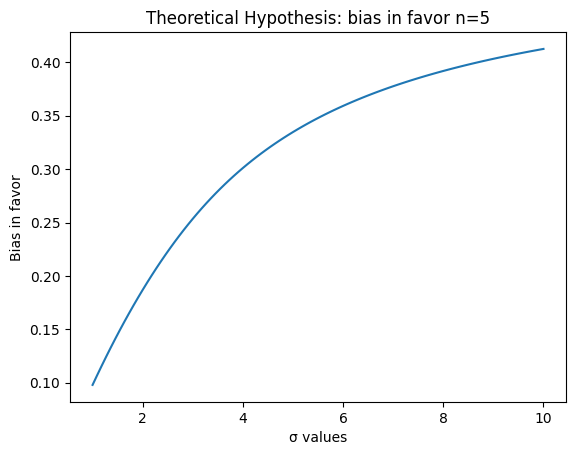

In [152]:
import matplotlib.pyplot as plt
# Example parameters
hypothesis = 1.0        # Known theta
mu_0 = 0.0         # Prior mean
tau_0 = 1.0        # Prior standard deviation
sigma = np.linspace(1, 10, 100)      # Likelihood standard deviation
n = 5        # Sample size
delta = 0.05     # Shift from the hypothesis

print("Bias in favor of the hypothesis:")
plt.plot(sigma,[theoretical_hypothesis_bias_against(sigma[i], n, hypothesis, delta) for i in range(100)])
plt.title(f"Theoretical Hypothesis: bias in favor n=5")
plt.xlabel('σ values')
plt.ylabel('Bias in favor')
plt.show()

## Hypothesis Bias In Favor

In [153]:
def theoretical_hypothesis_bias_in_favor(sigma, n, hypothesis, delta, mu_0 = 0, sigma_0 = 1):
    """
    Compute the bias in favor of the hypothesis theta.

    Parameters:
    mu_0 (float): Prior mean
    tau_0 (float): Prior standard deviation
    sigma (float): Known standard deviation of the data
    n (int): Sample size
    theta (float): Hypothesized mean
    delta (float): The specified shift from theta

    Returns:
    float: The bias in favor
    """
    # Step 1: Solve the inequality for "in favor" bias
    intervals = solve_rb_inequality(hypothesis, mu_0, sigma_0, sigma, n, bias="in favor")
    
    # Check if intervals are empty
    if not intervals:
        bias_in_favor = 0.0
    else:
        # Step 2: Compute expectations for theta + delta and theta - delta
        expectation_plus = compute_expectation(hypothesis, sigma, n, intervals, delta=delta)
        expectation_minus = compute_expectation(hypothesis, sigma, n, intervals, delta=-delta)

        # Step 3: Calculate the bias in favor
        bias_in_favor = max(expectation_plus, expectation_minus)
    
    return bias_in_favor


### Example

Bias in favor of the hypothesis:


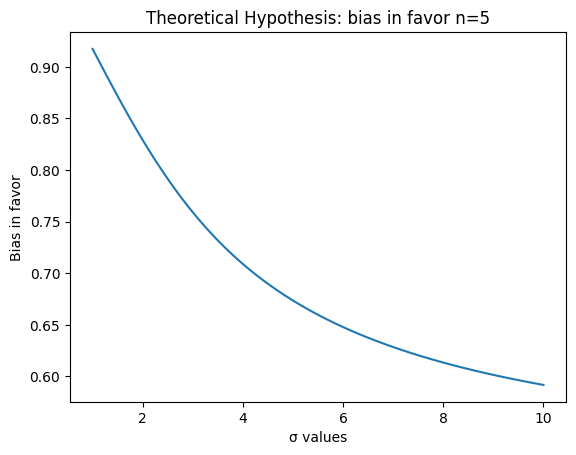

In [22]:
import matplotlib.pyplot as plt
# Example parameters
hypothesis = 1.0        # Known theta
mu_0 = 0.0         # Prior mean
sigma_0 = 1.0        # Prior standard deviation
sigma = np.linspace(1, 10, 100)      # Likelihood standard deviation
n = 5        # Sample size
delta = 0.05     # Shift from the hypothesis

print("Bias in favor of the hypothesis:")
plt.plot(sigma,[theoretical_hypothesis_bias_in_favor(sigma[i], n, hypothesis, delta) for i in range(100)])
plt.title(f"Theoretical Hypothesis: bias in favor n=5")
plt.xlabel('σ values')
plt.ylabel('Bias in favor')
plt.show()

In [155]:
n = [5,10,15,20] 
sigma = 1
hypothesis = 1
delta = 1 
[theoretical_hypothesis_bias_in_favor(sigma, n[i], hypothesis, delta) for i in range(4)]

[0.5163942450746577,
 0.1806886116443643,
 0.053833329377671366,
 0.014343359034066087]

# Theoretical Estimation Bias Calculations

## Estimation Bias Against

In [156]:
import numpy as np

def theoretical_estimation_bias_against(mu_0, tau_0, sigma, n, num_samples=10000):
    """
    Estimate the bias against in estimation using Monte Carlo simulation.
    
    Parameters:
    mu_0 (float): Prior mean
    tau_0 (float): Prior standard deviation
    sigma (float): Known standard deviation of the data
    n (int): Sample size
    num_samples (int): Number of samples for Monte Carlo simulation
    
    Returns:
    float: Estimated bias against
    """
    # Step 1: Sample theta from the prior
    theta_samples = np.random.normal(mu_0, tau_0, num_samples)
    
    # Step 2: For each theta, sample x̄ from p(x̄ | theta)
    se = sigma / np.sqrt(n)
    xbar_samples = np.random.normal(theta_samples, se)
    
    # Step 3: Compute posterior parameters for each sample
    tau_n_sq_inv = (1 / tau_0**2) + (n / sigma**2)
    tau_n_sq = 1 / tau_n_sq_inv
    mu_n = tau_n_sq * ((mu_0 / tau_0**2) + (n * xbar_samples / sigma**2))
    
    # Step 4: Compute RB(theta | x̄) for each sample
    ln_rb = 0.5 * np.log(tau_0**2 / tau_n_sq) \
            - ((theta_samples - mu_n)**2) / (2 * tau_n_sq) \
            + ((theta_samples - mu_0)**2) / (2 * tau_0**2)
    
    # Step 5: Estimate the bias against
    bias_against = np.mean(ln_rb <= 0)
    
    return bias_against


In [158]:
# Example parameters
mu_0 = 0.0         # Prior mean
tau_0 = 1.0        # Prior standard deviation
sigma = 1.0        # Known standard deviation
n = 50            # Sample size

# Estimate the bias against
bias_against = theoretical_estimation_bias_against(mu_0, tau_0, sigma, n, num_samples=1000000)
print(f"Estimated bias against in estimation: {bias_against}")


Estimated bias against in estimation: 0.031265


## Estimation Bias In Favor

In [62]:
import numpy as np
from scipy.stats import norm

def theoretical_estimation_bias_in_favor(
    mu_0,       # Prior mean
    tau_0,      # Prior standard deviation
    sigma,      # Known standard deviation of the data
    n,          # Sample size
    delta,      # Specified distance delta
    num_theta0_samples=1000,  # Number of theta_0 samples
    num_xbar_samples=1000     # Number of x̄ samples per θ and θ₀
):
    """
    Estimate the bias in favor in estimation using Monte Carlo simulation,
    including delta and supremum over theta at distance delta from theta_0.
    
    Parameters:
    mu_0 (float): Prior mean
    tau_0 (float): Prior standard deviation
    sigma (float): Known standard deviation of the data
    n (int): Sample size
    delta (float): Specified distance delta
    num_theta0_samples (int): Number of theta_0 samples
    num_xbar_samples (int): Number of x̄ samples per θ and θ₀
    
    Returns:
    float: Estimated bias in favor
    """
    # Step 1: Sample theta_0 from the prior
    theta0_samples = np.random.normal(mu_0, tau_0, num_theta0_samples)
    
    # Initialize an array to store the supremum probabilities for each theta_0
    supremum_probs = np.zeros(num_theta0_samples)
    
    # Precompute posterior variance (tau_n^2)
    tau_n_sq_inv = (1 / tau_0**2) + (n / sigma**2)
    tau_n_sq = 1 / tau_n_sq_inv
    
    # Standard error of the sample mean
    se = sigma / np.sqrt(n)
    
    for i, theta0 in enumerate(theta0_samples):
        # Generate θ values at a distance δ from θ₀
        theta_values = [theta0 - delta, theta0 + delta]
        
        max_prob = 0  # To store the maximum probability over θ
        
        for theta in theta_values:
            # Step 2: For each θ, simulate x̄ from p(x̄ | θ)
            xbar_samples = np.random.normal(theta, se, num_xbar_samples)
            
            # Step 3: Compute posterior mean μ_n for each x̄
            mu_n = tau_n_sq * ((mu_0 / tau_0**2) + (n * xbar_samples / sigma**2))
            
            # Step 4: Compute ln RB(θ₀ | x̄) for each x̄
            ln_rb = 0.5 * np.log(tau_0**2 / tau_n_sq) \
                    - ((theta0 - mu_n)**2) / (2 * tau_n_sq) \
                    + ((theta0 - mu_0)**2) / (2 * tau_0**2)
            
            # Step 5: Determine the proportion where ln RB(θ₀ | x̄) ≥ 0
            prob_in_favor = np.mean(ln_rb >= 0)
            
            # Update the maximum probability
            max_prob = max(max_prob, prob_in_favor)
        
        # Store the maximum probability for this θ₀
        supremum_probs[i] = max_prob
    
    # Step 6: Compute the expected value over θ₀
    bias_in_favor = np.mean(supremum_probs)
    
    return bias_in_favor


In [159]:
# Parameters
mu_0 = 0          # Prior mean
tau_0 = 1         # Prior standard deviation
sigma = 1         # Known standard deviation
n = 10            # Sample size
delta = 0.5       # Specified distance δ
num_theta0_samples = 1000    # Number of θ₀ samples
num_xbar_samples = 1000      # Number of x̄ samples per θ and θ₀

# Calculate bias in favor
bias_in_favor = theoretical_estimation_bias_in_favor(
    mu_0, tau_0, sigma, n, delta, num_theta0_samples, num_xbar_samples
)

print(f"Bias In Favor (Estimation): {bias_in_favor :.5f}")


Bias In Favor (Estimation): 0.68069


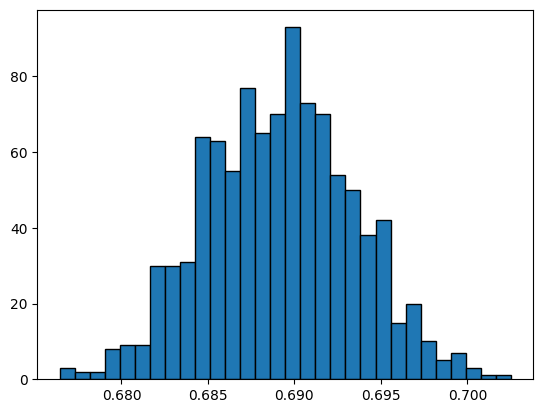

In [148]:
loops = 1000
bias_in_favor = np.zeros(loops)
for i in range(loops):
    bias_in_favor[i] = theoretical_estimation_bias_in_favor(
        mu_0, tau_0, sigma, n, delta, num_theta0_samples, num_xbar_samples
    )
plt.hist(bias_in_favor, bins=30, edgecolor='black')
plt.show()

In [147]:
print(f"Mean bias in favor: {np.mean(bias_in_favor) :.5f}")
print(f"Standard deviation of bias in favor: {np.std(bias_in_favor) :.5f}")
print(f"Samples = {loops}")

Mean bias in favor: 0.68899
Standard deviation of bias in favor: 0.00412
Samples = 1000
